## Part -1

### importing modules

In [7]:
import pandas as pd
import random
import numpy as  np
import math
from copy import deepcopy
import matplotlib.pyplot as plt
import operator
from copy import deepcopy
from collections import Counter
from keras.layers import Input, Dense
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn import mixture
from sklearn.cluster import AgglomerativeClustering

### dropping output column

In [8]:
original_data = pd.read_csv('data.csv')
total_y_values = original_data['xAttack']
original_data = original_data.drop('xAttack',axis = 1)

### Normalizing data

In [9]:
data = pd.read_csv('data.csv')
total_y_values = data['xAttack']
data = data.drop('xAttack',axis = 1)

data=data.astype('float128')
data_mean = deepcopy(data.mean())
data_std = deepcopy(data.std())
data =(data-data_mean)*np.float128(1.0)/data_std
print(data.head())

   duration   service  src_bytes  dst_bytes       hot  num_failed_logins  \
0 -0.114536 -0.425928  -0.010012  -0.034506 -0.090954          -0.026321   
1 -0.114536  0.362284  -0.010092  -0.039818 -0.090954          -0.026321   
2 -0.114536 -0.425928  -0.010023   0.077314 -0.090954          -0.026321   
3 -0.114536 -0.729086  -0.009539  -0.039818 -0.090954          -0.026321   
4 -0.114536  0.301652  -0.010092  -0.039818 -0.090954          -0.026321   

   num_compromised  num_root  num_file_creations  num_access_files  ...  \
0        -0.021938 -0.021801           -0.027915         -0.044086  ...   
1        -0.021938 -0.021801           -0.027915         -0.044086  ...   
2        -0.021938 -0.021801           -0.027915         -0.044086  ...   
3        -0.021938 -0.021801           -0.027915         -0.044086  ...   
4        -0.021938 -0.021801           -0.027915         -0.044086  ...   

   dst_host_count  dst_host_srv_count  dst_host_same_srv_rate  \
0       -1.690179          

In [10]:
data.iloc[:1,:]

,duration,service,src_bytes,dst_bytes,hot,num_failed_logins,num_compromised,num_root,num_file_creations,num_access_files,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,-0.114536,-0.425928,-0.010012,-0.034506,-0.090954,-0.026321,-0.021938,-0.021801,-0.027915,-0.044086,...,-1.690179,1.262846,1.06755,-0.441075,-0.25342,0.071029,-0.639487,-0.535321,-0.386069,-0.374975


### Neural Net code

In [11]:
def sigmoid(z):
    return (1.0 / (1.0 + np.exp(-z)))


# In[11]:


def sigmoid_der(z):
    return np.multiply(sigmoid(z), (1.0 - sigmoid(z)))


# In[12]:


def relu(z):
    return np.maximum(z, 0)


# In[13]:


def relu_der(x):
    x[x <= 0] = 0
    x[x > 0] = 1
    return x


# In[14]:


def tanh(x):
    return np.tanh(x)


# In[15]:


def tanh_der(x):
    return 1.0 - (np.power(tanh(x), 2))


# In[16]:


def softmax(Z):
    expA = np.exp(Z - Z.max(1).reshape(Z.shape[0], 1))
    esum = expA / np.sum(expA, 1).reshape(Z.shape[0], 1)
    return esum

def linear(z):
    return z

def linear_der(z):
    return 1


# In[17]:


def softmax_der(x):
    y = deepcopy(x)
    edeno = np.power(np.sum(np.exp(x)), 2)
    enumo = np.sum(np.exp(x))
    for ele in y:
        for k in range(len(ele)):
            tempy = y[0][k]
            y[0][k] = (np.exp(tempy) * (enumo - np.exp(tempy)) / edeno)
    return y


# ### Layer class
# >- layer class will hold all the information regarding each layer
# >- each layer will have many attributes such as
# >>- number of nodes in each layer
# >>- activation function
# >>- derivatives regarding gradient decent

# In[18]:


class layer:
    def __init__(self, layerno, num_of_nodes, activation_function, isinput,
                 isoutput, ishidden):
        self.layerno = layerno
        self.num_of_nodes = num_of_nodes
        self.activation_function = activation_function
        self.is_input_layer = isinput
        self.is_ouput_layer = isoutput
        self.is_hidden_layer = ishidden
        self.input = None
        self.output = None
        self.error_cost = np.float128(1.0)
        self.derivative_op = np.float128(1.0)
        self.derivative_act = np.float128(1.0)
        self.derivative_wt = np.float128(1.0)
        self.k_product = np.float128(1.0)


# ### Function that generate random weights of shape of ( layer n-1 , layer n )

# In[19]:


def getrandom_wts(numberofnodes_prev, numberofnodes_next):
    return (0.01 * (np.random.randn(numberofnodes_prev, numberofnodes_next)))


# ### Common activation fucntion that will be called

# In[20]:


def activation(z, function_name):
    if function_name == 'sigmoid':
        return sigmoid(z)
    if function_name == 'tanh':
        return tanh(z)
    if function_name == 'relu':
        return relu(z)
    if function_name == "softmax":
        return softmax(z)
    if function_name == "linear":
        return linear(z)


# In[21]:


def activation_der(z, function_name):
    if function_name == 'sigmoid':
        return sigmoid_der(z)
    if function_name == 'tanh':
        return tanh_der(z)
    if function_name == 'relu':
        return relu_der(z)
    if function_name == "softmax":
        return softmax_der(z)
    if function_name == "linear":
        return linear_der(z)


# ### Class neural net
# >- It holds the structure of the neural net
# >- It has following methods
# >- 1. Initializer :
# >>- it intializes the hyper parameters like learning rate, number of epochs and batch size.
# >- 2. Add layer:
# >>- It adds a layer to neural net, we can define activation function, number of nodes in each layer.
# >- 3. Forward propogation
# >- 4. Backward propogation
# >- 5. Predict
# >- 6. Fit
# >>- Train the neural network using forward and back ward propogation

# In[123]:


class neural_net:
    layerno = 0

    def __init__(self, numboflayer, learning_rate, epochs, batch_size):
        self.numboflayer = numboflayer
        self.layers = []
        self.weights = []
        self.bias = []
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weight_matrix = None
        self.batch_size = batch_size
        self.error_each_epoch = []
        self.acc_each_epoch = []
        neural_net.layerno = 0
        self.compressed_output = None
        self.bottleneck_layer_no = (numboflayer - 1)//2

    def predict(self, y, actual_y):
        rcount = 0
        wcount = 0
        for ind, i in enumerate(y):
            self.forward_propogation(np.array(i).reshape(1, len(i)))
            list_of_op = list(np.ndarray.flatten(self.layers[-1].output))
            index = list_of_op.index(max(list_of_op))
            if (actual_y[ind][index] == 1):
                rcount += 1
            else:
                wcount += 1
        print("right count: ", rcount)
        print("wrong count: ", wcount)
        print("Accuracy", rcount / (rcount + wcount))
        self.acc_each_epoch.append(rcount / (rcount + wcount))
        print()

    def predict_2(self, y):
        rcount = 0
        wcount = 0
        f = open("2018201004_prediction.csv", "w+")
        for ind, i in enumerate(y):
            self.forward_propogation(np.array(i).reshape(1, len(i)))
            list_of_op = list(np.ndarray.flatten(self.layers[-1].output))
            index = list_of_op.index(max(list_of_op))
            f.write(str(int(index)))
            if ind != (len(y) - 1):
                f.write("\n")

    def test_data(self, test_inp, test_op):
        self.test_inp = test_inp
        self.test_op = test_op

    def fit(self, x, y):
        for epoch in range(self.epochs):
            self.forward_propogation(x)
            self.backward_propogation(y)
            if epoch%25 == 0:
                print("Epoch",epoch)
                print("error",self.layers[-1].error)

#             if(error_batch/len(x) < 15 and not flag_of_learningrate):
#                 self.learning_rate = self.learning_rate/10
#                 flag_of_learningrate = 1
#            print(self.layers[-1].output)
#            self.predict(self.test_inp, self.test_op)
#             for layer in self.layers:
#                 if layer.layerno != 0:
#                     print("weights",self.weights[layer.layerno-1])
#                 print("layerno",layer.layerno)
#                 print("input",layer.input)
#                 print("output",layer.output)
#                 print("serivative1",layer.derivative_op)
#                 print("derivative2",layer.derivative_act)
#                 print("kproduct",layer.k_product)
#                 print("derivative3",layer.derivative_wt)

    def add_layer(self, num_of_nodes, activation_function):
        if neural_net.layerno == 0:
            temp_layer = layer(neural_net.layerno, num_of_nodes,
                               activation_function, True, False, False)
        elif neural_net.layerno == self.numboflayer - 1:
            temp_layer = layer(neural_net.layerno, num_of_nodes,
                               activation_function, False, True, False)
        else:
            temp_layer = layer(neural_net.layerno, num_of_nodes,
                               activation_function, False, False, True)

        neural_net.layerno += 1

        self.layers.append(temp_layer)

        if (temp_layer.is_input_layer == False):
            #self.weights.append(random_wts[temp_layer.layerno-1])
            #print(temp_layer.layerno)
            self.weights.append(
                getrandom_wts(self.layers[temp_layer.layerno - 1].num_of_nodes,
                              temp_layer.num_of_nodes))
            self.bias.append(np.random.randn(1, temp_layer.num_of_nodes))

        #self.weights = np.array(self.weights)
    def get_compressed_datamatrix(self,x):
        output_rows = []
        for rowindex in range(len(x)):
            self.forward_propogation(
                    np.array(x[rowindex]).reshape(1, len(x[rowindex])))
            compressed_row = np.ndarray.flatten(self.layers[self.bottleneck_layer_no].output)
            output_rows.append(compressed_row)
        return np.stack(output_rows)

    def forward_propogation(self, x):

        for layer in self.layers:
            # print(layer.layerno)
            if layer.layerno == 0:
                layer.input = x
                if layer.activation_function:
                    layer.output = activation(layer.input,
                                              layer.activation_function)
                else:
                    layer.output = x
            else:
                layer.input = np.dot(
                    self.layers[layer.layerno - 1].output, self.weights[
                        layer.layerno - 1]) + self.bias[layer.layerno - 1]
                layer.output = activation(layer.input,
                                          layer.activation_function)
#                 if (layer.layerno + 1) < len(self.layers):
#                     self.layers[layer.layerno + 1].input = layer.output
# print(layer.input)
#  print(layer.output)

    def error(self, predicted, actual):
        return np.mean(np.power((np.array(predicted) - np.array(actual)), 2))

    def error_der(self, predicted, actual):
        return 2 * (predicted - actual)

    def error2(self, predicted, actual):
        epsilon = 1e-12
        predictions = np.clip(predicted, epsilon, 1. - epsilon)
        N = predictions.shape[1]
        ce = -np.sum(actual * np.log(predictions + 1e-9)) / N
        return ce

    def error2_der(self, predicted, actual):
        return -1 * ((actual * (1 / predicted)) + (1 - actual) * (
            (1 / (1 - predicted))))

    def weights_behind(self, layer_):
        return self.weights[layer_.layerno - 1]

    def weights_ahead(self, layer_):
        return self.weights[layer_.layerno]

    def layer_behind(self, layer_):
        return self.layers[layer_.layerno - 1]

    def layer_ahead(self, layer_):
        return self.layers[layer_.layerno + 1]

    def backward_propogation(self, y):

        stored = np.float128(1.0)

        for curr_layer in self.layers[::-1]:
            if curr_layer.layerno == 0:
                continue
            if curr_layer.layerno == len(self.layers) - 1:

                stored = np.dot(self.error(curr_layer.output, y), stored)
                curr_layer.error = stored
                # print("error",curr_layer.error)

                curr_layer.derivative_op = self.error_der(curr_layer.output, y)
                #  print(curr_layer.derivative_op,curr_layer.derivative_op.shape)

                curr_layer.derivative_act = activation_der(
                    curr_layer.input, curr_layer.activation_function)
                #  print(curr_layer.derivative_act,curr_layer.derivative_act.shape)

                curr_layer.k_product = curr_layer.derivative_op * curr_layer.derivative_act
                # print(curr_layer.k_product,curr_layer.k_product.shape)

                #curr_layer.k_product = curr_layer.k_product.reshape(1,curr_layer.derivative_act.shape[0])
                curr_layer.derivative_wt = np.dot(
                    (self.layers[curr_layer.layerno - 1].output).T,
                    curr_layer.k_product)

                #self.weights[curr_layer.layerno - 1] -= self.learning_rate * curr_layer.derivative_wt

            else:
                #   print(curr_layer.layerno)
                curr_layer.error = None
                curr_layer.derivative_act = activation_der(
                    curr_layer.input, curr_layer.activation_function)
                curr_layer.derivative_op = np.dot(
                    self.layers[curr_layer.layerno + 1].k_product,
                    (self.weights_ahead(curr_layer)).T)
                curr_layer.k_product = curr_layer.derivative_op * curr_layer.derivative_act
                #if curr_layer.layerno != 1:
                curr_layer.derivative_wt = np.dot(
                    (self.layer_behind(curr_layer).output).T,
                    curr_layer.k_product)


#                 else:
#                     curr_layer.derivative_wt = np.dot( (self.layer_behind(curr_layer).input).T , curr_layer.k_product)

        for w_no, weight in enumerate(self.weights):
            self.weights[w_no] -= (self.learning_rate/len(y)) * (
                self.layers[w_no + 1].derivative_wt)
            self.bias[w_no] -= (self.learning_rate/len(y)) * (
                np.sum(self.layers[w_no + 1].k_product , axis = 0))

### A. Linear 3 layer autoencoder

In [12]:
net = neural_net(3,0.01,700,100)
net.add_layer(29,"linear")
net.add_layer(14,"linear")
net.add_layer(29,"linear")

data_np_version = np.array(data)

net.fit(data_np_version,data_np_version)

compressed_datamatrix_1 = net.layers[net.bottleneck_layer_no].output

compressed_datamatrix_1.shape

Epoch 0
error 1.9857316605131143265
Epoch 25
error 0.8021356765838160936
Epoch 50
error 0.5748553229405917558
Epoch 75
error 0.50587611261369945764
Epoch 100
error 0.42652969260406360774
Epoch 125
error 0.37221645012901084866
Epoch 150
error 0.31542410731294543704
Epoch 175
error 0.2665095907049613667
Epoch 200
error 0.22085994134178593012
Epoch 225
error 0.18127008011836367259
Epoch 250
error 0.15305991944976561187
Epoch 275
error 0.13473795510380176672
Epoch 300
error 0.12264765982890165261
Epoch 325
error 0.115176873771683020246
Epoch 350
error 0.11114064384448311402
Epoch 375
error 0.109116480975817029355
Epoch 400
error 0.108037465050605764126
Epoch 425
error 0.10734546333894614087
Epoch 450
error 0.106809839874553505475
Epoch 475
error 0.10634657536211736206
Epoch 500
error 0.10592524297933476902
Epoch 525
error 0.10553327985097851643
Epoch 550
error 0.10516413526125378224
Epoch 575
error 0.104813561740091180406
Epoch 600
error 0.1044784320739657585
Epoch 625
error 0.104156314318

(24998, 14)

In [89]:
output_label = kmeans_final(5,compressed_datamatrix_1)
print()
print("Purity of k means: ")
print()
p1 = calculate_purity(output_label)


Purity of k means: 

cluster :  0 , Maximum label present :  probe , No of times:  1021 , Purity : 0.7190140845070423
cluster :  1 , Maximum label present :  dos , No of times:  6943 , Purity : 0.8169196376044241
cluster :  2 , Maximum label present :  normal , No of times:  1381 , Purity : 0.7891428571428571
cluster :  3 , Maximum label present :  normal , No of times:  102 , Purity : 0.9807692307692307
cluster :  4 , Maximum label present :  normal , No of times:  10067 , Purity : 0.7612098298676748
Avg purity :  0.8134111279782459


In [93]:
output_label = gmm_implementation(compressed_datamatrix_1)
print()
print("Purity of GMM : ")
print()
p2 = calculate_purity(output_label)

Counter({0: 7278, 4: 6439, 1: 6279, 3: 4994, 2: 8})

Purity of GMM : 

cluster :  0 , Maximum label present :  normal , No of times:  6558 , Purity : 0.9010717230008244
cluster :  1 , Maximum label present :  dos , No of times:  6279 , Purity : 1.0
cluster :  2 , Maximum label present :  normal , No of times:  8 , Purity : 1.0
cluster :  3 , Maximum label present :  normal , No of times:  1902 , Purity : 0.38085702843412095
cluster :  4 , Maximum label present :  normal , No of times:  4896 , Purity : 0.7603665165398353
Avg purity :  0.8084590535949563


In [94]:
output_label = hmm_implementation(compressed_datamatrix_1)
print()
print("Purity of hiearichal clustering: ")
print()
p3 = calculate_purity(output_label)

Counter({0: 24989, 2: 6, 1: 1, 3: 1, 4: 1})

Purity of hiearichal clustering: 

cluster :  0 , Maximum label present :  normal , No of times:  13360 , Purity : 0.5346352395053824
cluster :  1 , Maximum label present :  probe , No of times:  1 , Purity : 1.0
cluster :  2 , Maximum label present :  r2l , No of times:  4 , Purity : 0.6666666666666666
cluster :  3 , Maximum label present :  normal , No of times:  1 , Purity : 1.0
cluster :  4 , Maximum label present :  normal , No of times:  1 , Purity : 1.0
Avg purity :  0.8402603812344097


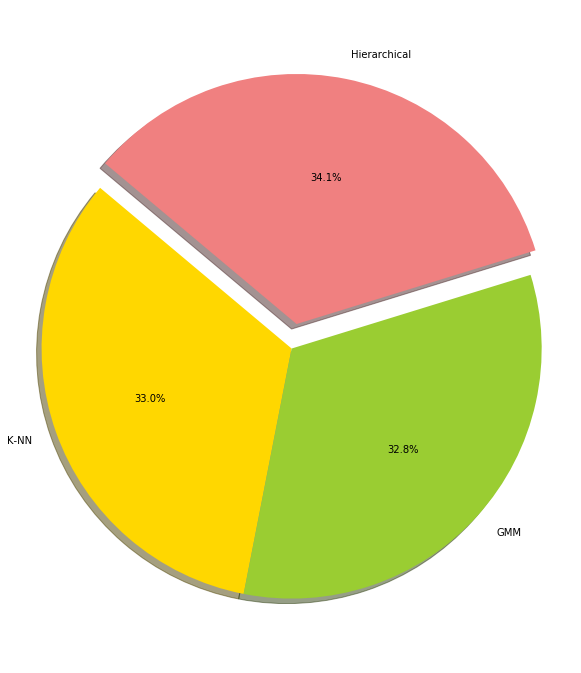

In [95]:
pie_chart(p1,p2,p3)

### Non - linear 3-layer auto encoder

In [96]:
net = neural_net(3,0.1,700,100)
net.add_layer(29,"linear")
net.add_layer(14,"sigmoid")
net.add_layer(29,"linear")

data_np_version = np.array(data)


net.fit(data_np_version,data_np_version)



compressed_datamatrix_2 = net.layers[net.bottleneck_layer_no].output


Epoch 0
error 2.3836873029912741399
Epoch 25
error 0.67925656207408250737
Epoch 50
error 0.56966022106047877556
Epoch 75
error 0.5184407659423887813
Epoch 100
error 0.47279038009029368485
Epoch 125
error 0.43372882774276372788
Epoch 150
error 0.40511617446250418412
Epoch 175
error 0.38432029915118134624
Epoch 200
error 0.36679664303941043443
Epoch 225
error 0.35085739623944821127
Epoch 250
error 0.33607826450963026739
Epoch 275
error 0.32330122186190610452
Epoch 300
error 0.31277025292211736655
Epoch 325
error 0.30433149997567819268
Epoch 350
error 0.2975327238405586262
Epoch 375
error 0.29191088804010658514
Epoch 400
error 0.2871194082578539624
Epoch 425
error 0.28291977378005565074
Epoch 450
error 0.27914721940651733177
Epoch 475
error 0.2757319062987885938
Epoch 500
error 0.2726193359872230826
Epoch 525
error 0.26976359387286819502
Epoch 550
error 0.26713141281666192626
Epoch 575
error 0.26469636310922274613
Epoch 600
error 0.2624358378211774457
Epoch 625
error 0.2603295751472684177

In [120]:
output_label = kmeans_final(5,compressed_datamatrix_2)
print()
print("Purity of k means: ")
print()
p1 = calculate_purity(output_label)



Purity of k means: 

cluster :  0 , Maximum label present :  normal , No of times:  9358 , Purity : 0.8713221601489758
cluster :  1 , Maximum label present :  dos , No of times:  6852 , Purity : 0.817076079179585
cluster :  2 , Maximum label present :  normal , No of times:  425 , Purity : 0.9976525821596244
cluster :  3 , Maximum label present :  normal , No of times:  2155 , Purity : 0.3978951255539143
cluster :  4 , Maximum label present :  dos , No of times:  28 , Purity : 0.9333333333333333
Avg purity :  0.8034558560750866


Counter({3: 8754, 1: 6933, 4: 3334, 0: 3015, 2: 2962})

Purity of GMM : 

cluster :  0 , Maximum label present :  dos , No of times:  3015 , Purity : 1.0
cluster :  1 , Maximum label present :  normal , No of times:  4503 , Purity : 0.6495023799221117
cluster :  2 , Maximum label present :  dos , No of times:  1366 , Purity : 0.4611748818365969
cluster :  3 , Maximum label present :  normal , No of times:  8301 , Purity : 0.9482522275531186
cluster :  4 , Maximum label present :  dos , No of times:  3334 , Purity : 1.0
Avg purity :  0.8117858978623655
Counter({0: 24972, 2: 23, 1: 1, 3: 1, 4: 1})

Purity of hiearichal clustering: 

cluster :  0 , Maximum label present :  normal , No of times:  13350 , Purity : 0.5345987506006727
cluster :  1 , Maximum label present :  probe , No of times:  1 , Purity : 1.0
cluster :  2 , Maximum label present :  normal , No of times:  12 , Purity : 0.5217391304347826
cluster :  3 , Maximum label present :  normal , No of times:  1 , Purity : 1.0
cluster

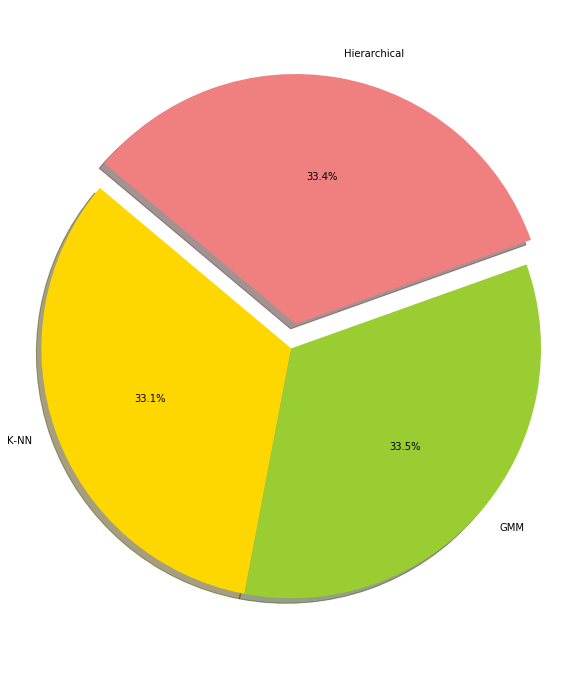

In [121]:
output_label = gmm_implementation(compressed_datamatrix_2)
print()
print("Purity of GMM : ")
print()
p2 = calculate_purity(output_label)
output_label = hmm_implementation(compressed_datamatrix_2)
print()
print("Purity of hiearichal clustering: ")
print()
p3 = calculate_purity(output_label)
pie_chart(p1,p2,p3)

### B. Non-linear 5 layer autoencoder

>- relu

In [122]:
net = neural_net(5,0.1,700,100)
net.add_layer(29,"linear")
net.add_layer(21,"sigmoid")
net.add_layer(14,"relu")
net.add_layer(21,"sigmoid")
net.add_layer(29,"linear")

In [123]:
net.fit(data_np_version,data_np_version)

Epoch 0
error 1.8770826017779403505
Epoch 25
error 0.9999576483913372791
Epoch 50
error 0.99995527639746896215
Epoch 75
error 0.9999518508632823271
Epoch 100
error 0.9999464823784971663
Epoch 125
error 0.99993750876136047864
Epoch 150
error 0.99992144611963930823
Epoch 175
error 0.9998899416505498783
Epoch 200
error 0.9998190188641997051
Epoch 225
error 0.9996185903357861092
Epoch 250
error 0.99874798866112202036
Epoch 275
error 0.9882031585550292669
Epoch 300
error 0.84934365986297216244
Epoch 325
error 0.7803393492439435471
Epoch 350
error 0.77843359898544727384
Epoch 375
error 0.7704178865486974485
Epoch 400
error 0.7552716333388158816
Epoch 425
error 0.71895534589391969056
Epoch 450
error 0.66915467213181536354
Epoch 475
error 0.64078221758197207884
Epoch 500
error 0.63572061134058948756
Epoch 525
error 0.62571076774061493354
Epoch 550
error 0.62574177782352526745
Epoch 575
error 0.61993304606846149946
Epoch 600
error 0.6167042735429102013
Epoch 625
error 0.6131821859357270159
Epoc

In [125]:
compressed_datamatrix_3 = net.layers[net.bottleneck_layer_no].output

array([[0.        , 0.        , 1.4780203 , ..., 0.        , 0.        ,
        0.        ],
       [1.57994985, 2.35903166, 2.37157482, ..., 0.65510299, 0.        ,
        0.        ],
       [0.        , 0.        , 1.46858955, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.16983629, 0.78647041, ..., 1.27563785, 0.        ,
        0.        ],
       [0.        , 0.        , 1.93228751, ..., 0.        , 0.        ,
        0.        ],
       [0.73117184, 1.97165237, 0.        , ..., 3.25972583, 0.        ,
        0.        ]], dtype=float128)


Purity of k means: 

cluster :  0 , Maximum label present :  normal , No of times:  13364 , Purity : 0.8384991843393148
cluster :  2 , Maximum label present :  dos , No of times:  1360 , Purity : 0.5972771190162495
cluster :  4 , Maximum label present :  dos , No of times:  6741 , Purity : 0.9938080495356038
Avg purity :  0.8098614509637226

Counter({3: 13145, 0: 6394, 4: 2720, 1: 1885, 2: 854})

Purity of GMM : 

cluster :  0 , Maximum label present :  dos , No of times:  6393 , Purity : 0.999843603378167
cluster :  1 , Maximum label present :  normal , No of times:  1380 , Purity : 0.7320954907161804
cluster :  2 , Maximum label present :  normal , No of times:  519 , Purity : 0.607728337236534
cluster :  3 , Maximum label present :  normal , No of times:  11381 , Purity : 0.8658044883986307
cluster :  4 , Maximum label present :  dos , No of times:  1790 , Purity : 0.6580882352941176
Avg purity :  0.772712031004726
Counter({0: 24992, 1: 2, 2: 2, 3: 1, 4: 1})

Purity of hiearichal c

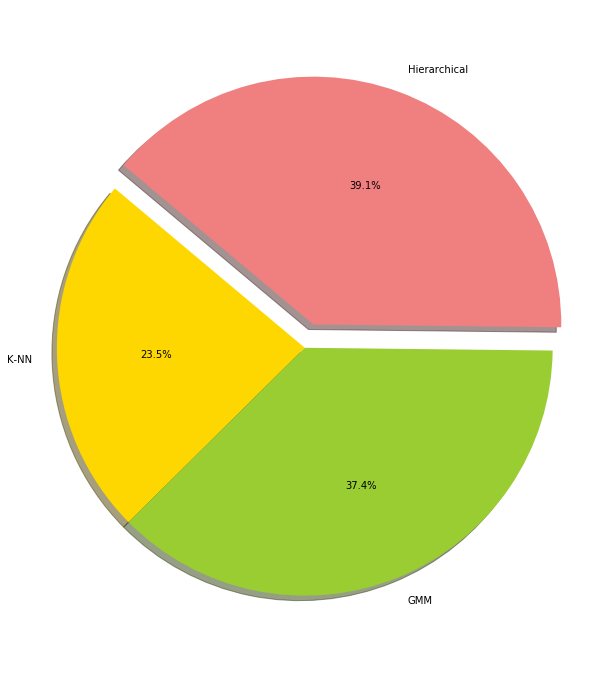

In [174]:
output_label = kmeans_final(5,compressed_datamatrix_3)
print()
print("Purity of k means: ")
print()
p1 = calculate_purity(output_label)
print()
output_label = gmm_implementation(compressed_datamatrix_3)
print()
print("Purity of GMM : ")
print()
p2 = calculate_purity(output_label)
output_label = hmm_implementation(compressed_datamatrix_3)
print()
print("Purity of hiearichal clustering: ")
print()
p3 = calculate_purity(output_label)
pie_chart(p1,p2,p3)

>- Relu-sigmoid=relu

### Non - linear 5 - layer auto encoder

In [177]:
net = neural_net(5,0.1,700,100)
net.add_layer(29,"linear")
net.add_layer(21,"sigmoid")
net.add_layer(14,"linear")
net.add_layer(21,"sigmoid")
net.add_layer(29,"linear")

net.fit(data_np_version,data_np_version)

Epoch 0
error 1.9060327859654615885
Epoch 25
error 0.99854373590505674245
Epoch 50
error 0.9908663456663979217
Epoch 75
error 0.80226656481340125494
Epoch 100
error 0.8626032682466364884
Epoch 125
error 0.822992619027252807
Epoch 150
error 0.79670237458316680765
Epoch 175
error 0.8050176673839734031
Epoch 200
error 0.7629664413173137871
Epoch 225
error 0.67832846560319968744
Epoch 250
error 0.6280673375115964987
Epoch 275
error 0.62117325620634942043
Epoch 300
error 0.6590000807300784888
Epoch 325
error 0.62517908607560399644
Epoch 350
error 0.6285966199841003125
Epoch 375
error 0.6368977974710101125
Epoch 400
error 0.6122189431796638793
Epoch 425
error 0.58759953114820199035
Epoch 450
error 0.5686749677797164376
Epoch 475
error 0.55796647863379806817
Epoch 500
error 0.54529923275483025964
Epoch 525
error 0.580635582535032787
Epoch 550
error 0.5523747046948345635
Epoch 575
error 0.5216719668194879252
Epoch 600
error 0.5094584977120508579
Epoch 625
error 0.5009799902195672429
Epoch 650


In [178]:
compressed_datamatrix_4 = net.layers[net.bottleneck_layer_no].output


Purity of k means: 

cluster :  0 , Maximum label present :  normal , No of times:  2 , Purity : 0.5
cluster :  1 , Maximum label present :  normal , No of times:  1974 , Purity : 0.6806896551724138
cluster :  2 , Maximum label present :  normal , No of times:  10926 , Purity : 0.8688667992047714
cluster :  3 , Maximum label present :  dos , No of times:  7783 , Purity : 0.8176279020905557
Avg purity :  0.7167960891169352

Counter({4: 7784, 3: 6631, 1: 5182, 2: 3336, 0: 2065})

Purity of GMM : 

cluster :  0 , Maximum label present :  normal , No of times:  1379 , Purity : 0.6677966101694915
cluster :  1 , Maximum label present :  normal , No of times:  3766 , Purity : 0.7267464299498263
cluster :  2 , Maximum label present :  dos , No of times:  1727 , Purity : 0.5176858513189448
cluster :  3 , Maximum label present :  dos , No of times:  6631 , Purity : 1.0
cluster :  4 , Maximum label present :  normal , No of times:  7656 , Purity : 0.9835560123329907
Avg purity :  0.7791569807542

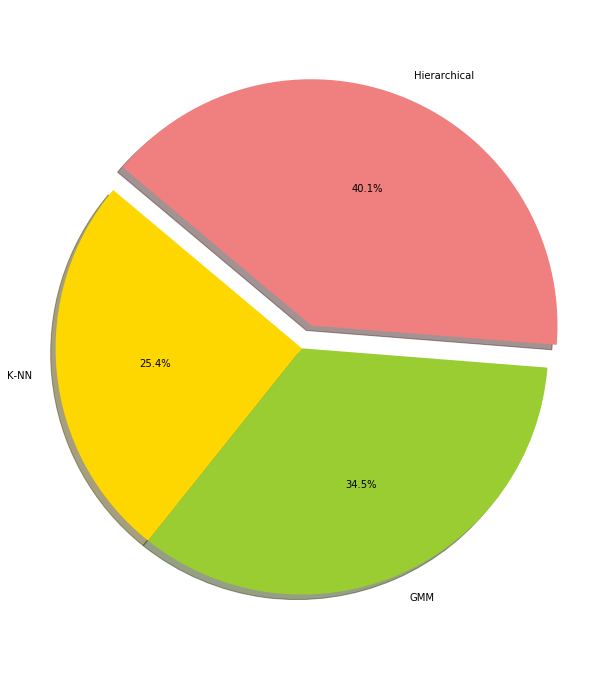

In [194]:
output_label = kmeans_final(5,compressed_datamatrix_4)
print()
print("Purity of k means: ")
print()
p1 = calculate_purity(output_label)
print()
output_label = gmm_implementation(compressed_datamatrix_4)
print()
print("Purity of GMM : ")
print()
p2 = calculate_purity(output_label)
output_label = hmm_implementation(compressed_datamatrix_4)
print()
print("Purity of hiearichal clustering: ")
print()
p3 = calculate_purity(output_label)
pie_chart(p1,p2,p3)

### Non linear 7 layer network

In [195]:
net = neural_net(7,0.5,150,100)
net.add_layer(29,"linear")
net.add_layer(21,"sigmoid")
net.add_layer(17,"sigmoid")
net.add_layer(14,"sigmoid")
net.add_layer(17,"sigmoid")
net.add_layer(21,"sigmoid")
net.add_layer(29,"linear")

net.fit(data_np_version,data_np_version)
compressed_datamatrix_5 = net.layers[net.bottleneck_layer_no].output

Epoch 0
error 1.9444722128157175096
Epoch 25
error 0.9999599967998280343
Epoch 50
error 0.9999599967998280343
Epoch 75
error 0.9999599967998280343
Epoch 100
error 0.9999599967998280343
Epoch 125
error 0.9999599967998280343



Purity of k means: 

cluster :  1 , Maximum label present :  probe , No of times:  849 , Purity : 0.4215491559086395
cluster :  2 , Maximum label present :  normal , No of times:  12370 , Purity : 0.9171115065243179
cluster :  3 , Maximum label present :  dos , No of times:  1637 , Purity : 0.4971150926207106
cluster :  4 , Maximum label present :  dos , No of times:  6177 , Purity : 0.9958084797678542
Avg purity :  0.7078960587053805

Counter({1: 7784, 0: 6631, 4: 5182, 2: 3336, 3: 2065})

Purity of GMM : 

cluster :  0 , Maximum label present :  dos , No of times:  6631 , Purity : 1.0
cluster :  1 , Maximum label present :  normal , No of times:  7656 , Purity : 0.9835560123329907
cluster :  2 , Maximum label present :  dos , No of times:  1727 , Purity : 0.5176858513189448
cluster :  3 , Maximum label present :  normal , No of times:  1379 , Purity : 0.6677966101694915
cluster :  4 , Maximum label present :  normal , No of times:  3766 , Purity : 0.7267464299498263
Avg purity :  0.

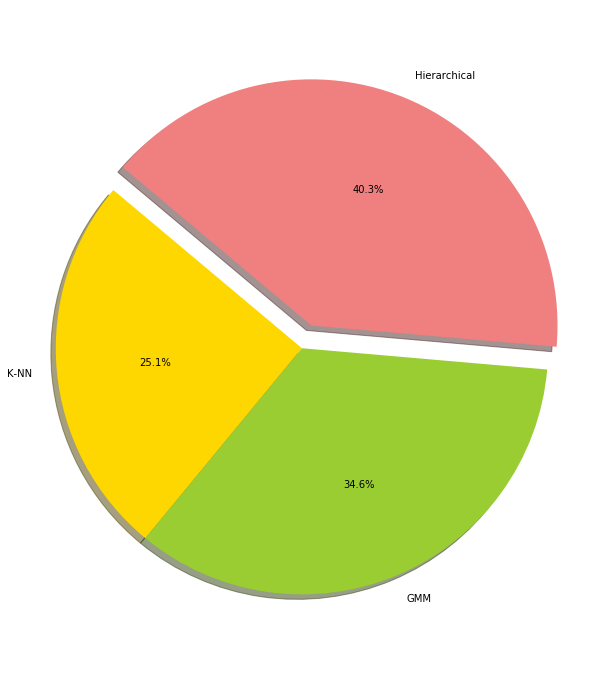

In [208]:
output_label = kmeans_final(5,compressed_datamatrix_4)
print()
print("Purity of k means: ")
print()
p1 = calculate_purity(output_label)
print()
output_label = gmm_implementation(compressed_datamatrix_4)
print()
print("Purity of GMM : ")
print()
p2 = calculate_purity(output_label)
output_label = hmm_implementation(compressed_datamatrix_4)
print()
print("Purity of hiearichal clustering: ")
print()
p3 = calculate_purity(output_label)
pie_chart(p1,p2,p3)

### Code for K - Means clustering

In [137]:

def ecludian(row1,row2):
    dist = 0.0
    dist += math.sqrt(sum((np.array(row1)-np.array(row2))**2))
    return dist


# In[79]:


def assigncluster(centroid , row):
    mintill = 9999999999
    clust = -1
    for i in centroid:
        dist  = ecludian(row,i)
        if(dist < mintill):
            mintill = dist
            clust = i
    return clust


# In[80]:


def recalculate_centroid(clusters,data):
    newcentroid = []
    for i in clusters.keys():
        sumc = [0]*len(clusters[i][0])
        for j in range(len(clusters[i])):
            #print(clusters[i],"clusteri")
            #print(clusters[i][j],"what is this")
            sumc = sumc + np.array(clusters[i][j])  #data.loc[index.get_loc(clusters[i][j] )]
            #print(sumc,"sums")                       
        newcentroid.append(tuple(sumc/len(clusters[i])))
    return newcentroid


# In[81]:


def getrandomcentorid(k,data):
    centroids = []
    for i in range(k):
        rand = random.randint(0,len(data)-1)
        randval = tuple(data.loc[rand].values)
        while randval in centroids:
            randval = tuple(data.loc[random.randint(0,len(data)-1)])
        centroids.append(randval)
    return centroids


# In[82]:


def buildcluster(k,data,centroids):
    clu = {}
    for c in centroids:
        clu[c] = []
    for i,row in data.iterrows():
        rown = tuple(row)
        #print(assigncluster(centroids,rown))
        clu[assigncluster(centroids,rown)].append(rown)
        #print(rown)
    return clu


# In[83]:


def converge(cone,ctwo,tolerance,k):
    countofpos = 0
    for i in range(k):
        dist = ecludian(cone[i],ctwo[i])
        if(dist <= tolerance):
            countofpos += 1
    if(countofpos == k):
        return True
    else:
        return False


# In[ ]:





# In[84]:


def kmeans(data,k):
    centroid = getrandomcentorid(k,data)
    c1 = deepcopy(centroid)
    
    #print(c1)
    #print(len(c1))
    #print(assigncluster(c1,c1[0]),"assigned")
    #print(c1)
    clusters = buildcluster(k,data,c1)
    #print(clusters)
    #print(len(clusters.keys()),"keys")
    newcentroid = recalculate_centroid(clusters,data)
    iterations = 0
    while not converge(c1,newcentroid,0,k) :
        print(iterations)
        c1 = newcentroid
        clusters = buildcluster(k,data,c1)
        newcentroid = recalculate_centroid(clusters,data)
        iterations += 1
    return clusters
    print("final clusters",clusters)


# In[85]:


#data_for_kmeans = pd.DataFrame(pro_x)
#data_for_kmeans = (data_for_kmeans - data_for_kmeans.mean())/data_for_kmeans.std()
# print(data_for_kmeans)
# data_for_kmeans.describe()
#data_for_kmeans.columns = list(data)
# data_for_kmeans = data_for_kmeans
# clusters = kmeans(data_for_kmeans,5)

# clusterone = clusters[list(clusters.keys())[4]]
# results = []
# index = -1
# for i in clusterone:
#     for no,j in original_data.iterrows():
#         if tuple(j) == i:
#             index = no
#             break
#     results.append(total_y_values.iloc[index])


# In[86]:


def getdistances(data,centers,i):
    return  np.linalg.norm(data - centers[i], axis=1)


# In[87]:


def geterror(centernew,centerold):
    return np.linalg.norm(centernew - centerold)


# In[88]:


def getnewcenters(k,data,centers_new,clusters):
    for i in range(k):
        centers_new[i] = np.mean(data[clusters == i], axis=0)
    return centers_new


# In[116]:





# In[117]:



In [159]:
def kmeans_final(k,pro_x):
    n = pro_x.shape[0]
    data = pro_x
    #print(pro_x.shape[1])


    centers = np.random.randn(k,pro_x.shape[1])
    #print(centers)
    centers_old = np.zeros(centers.shape) 
    #print(centers_old.shape)
    centers_new = deepcopy(centers) 

    #print(data.shape)
    clusters = np.zeros(n)
    #print()
    distances = np.zeros((n,k))
    #print(distances.shape)

    error = geterror(centers_new,centers_old)

    iterations = 0 
    while error >= 0.00: #and iterations <= 1000:

        for i in range(k):
            distances[:,i] = getdistances(data,centers,i)

        clusters = np.argmin(distances, axis = 1)

        centers_old = deepcopy(centers_new)

        centers_new = getnewcenters(k,data,centers_new,clusters)


        error = geterror(centers_new,centers_old)
        iterations += 1

    purity = []
    output_labels = []

    for i in range(k):
        output_labels.append([])

    total_for_k_means = np.array(total_y_values)
    for i in range(n):
        output_labels[clusters[i]].append(total_y_values[i])
    return output_labels

In [170]:
def calculate_purity(output_labels):
    purity = []
    for i in range(5):
        if(len(output_label[i]) != 0 ):
            max_label = max(set(output_labels[i]), key=output_labels[i].count)
            #print(max_label)
            dictio = Counter(output_labels[i])
            purity.append(dictio[max_label]/len(output_labels[i]))
            
            print("cluster : ",i,", Maximum label present : ",max_label,", No of times: ",dictio[max_label],", Purity :",purity[i])
        if(len(output_label[i]) == 0 ):
            purity.append(0)
    sumavg = 0
    cnt = 0
    for i in purity :
        if(i != 0 ):
            sumavg += i
            cnt += 1
    avg_purity = sumavg/cnt
    print("Avg purity : ", avg_purity)
    return purity
    

In [301]:
# for i in output_labels:


cluster :  0 , Maximum label present :  dos , No of times:  8085 , Purity : 0.8683277843411019
cluster :  1 , Maximum label present :  dos , No of times:  385 , Purity : 0.782520325203252
cluster :  2 , Maximum label present :  normal , No of times:  10921 , Purity : 0.8852233119883278
cluster :  3 , Maximum label present :  normal , No of times:  527 , Purity : 0.947841726618705
cluster :  4 , Maximum label present :  normal , No of times:  1572 , Purity : 0.6828844483058211
Avg purity :  0.8333595192914416


### Code for GMM

In [3]:
def gmm_implementation(compressed_datamatrix_1):
    clf = mixture.GaussianMixture(n_components=5)
    labels = clf.fit_predict(compressed_datamatrix_1)
    k = 5
    n = len(compressed_datamatrix_1)
    print(Counter(labels))
    output_labels3 = []
    for i in range(k):
        output_labels3.append([])

    total_for_k_means = np.array(total_y_values)
    for i in range(n):
        output_labels3[labels[i]].append(total_y_values[i])
    return output_labels3

In [302]:

clf = mixture.GaussianMixture(n_components=5)
labels = clf.fit_predict(compressed_datamatrix_1)
k = 5
n = len(compressed_datamatrix)



print(Counter(labels))


# In[95]:


output_labels3 = []

for i in range(k):
    output_labels3.append([])

total_for_k_means = np.array(total_y_values)
for i in range(n):
    output_labels3[labels[i]].append(total_y_values[i])


# In[96]:


for i in output_labels3:
    print(len(i))
purity3 = []
for i in range(k):
    max_label = max(set(output_labels3[i]), key=output_labels3[i].count)
    dictio = Counter(output_labels3[i])
    purity3.append(dictio[max_label]/len(output_labels3[i]))
    print("cluster : ",i,", Maximum label present : ",max_label,", No of times: ",dictio[max_label],", Purity :",purity3[i])

print("Avg purity : ", sum(purity3)/len(purity3))


Counter({4: 11709, 0: 6330, 1: 4080, 3: 2335, 2: 544})
6330
4080
544
2335
11709
cluster :  0 , Maximum label present :  dos , No of times:  6330 , Purity : 1.0
cluster :  1 , Maximum label present :  normal , No of times:  2796 , Purity : 0.6852941176470588
cluster :  2 , Maximum label present :  probe , No of times:  543 , Purity : 0.9981617647058824
cluster :  3 , Maximum label present :  dos , No of times:  1363 , Purity : 0.5837259100642398
cluster :  4 , Maximum label present :  normal , No of times:  10110 , Purity : 0.8634383807327697
Avg purity :  0.8261240346299902


### Code for hiraerichal clustering

In [5]:
def hmm_implementation(compressed_datamatrix_1):
    cluster_hir = AgglomerativeClustering(n_clusters=5, linkage='single')
    labels4 = cluster_hir.fit_predict(compressed_datamatrix_1)
    k = 5
    n = len(compressed_datamatrix_1)


    print(Counter(labels4))
    output_labels4 = []

    for i in range(k):
        output_labels4.append([])

    total_for_k_means = np.array(total_y_values)
    for i in range(n):
        output_labels4[labels4[i]].append(total_y_values[i])
    return output_labels4

In [303]:
from sklearn.cluster import AgglomerativeClustering

cluster_hir = AgglomerativeClustering(n_clusters=5,  linkage='single')  
labels4 = cluster_hir.fit_predict(compressed_datamatrix_1)
k = 5
n = len(compressed_datamatrix)

# In[98]:


print(Counter(labels4))


# In[99]:


output_labels4 = []

for i in range(k):
    output_labels4.append([])

total_for_k_means = np.array(total_y_values)
for i in range(n):
    output_labels4[labels4[i]].append(total_y_values[i])


# In[100]:


for i in output_labels4:
    print(len(i))
purity4 = []
for i in range(k):
    max_label = max(set(output_labels4[i]), key=output_labels4[i].count)
    dictio = Counter(output_labels4[i])
    purity4.append(dictio[max_label]/len(output_labels4[i]))
    print("cluster : ",i,", Maximum label present : ",max_label,", No of times: ",dictio[max_label],", Purity :",purity4[i])

print("Avg purity : ", sum(purity4)/len(purity4))


Counter({0: 24989, 2: 6, 1: 1, 3: 1, 4: 1})
24989
1
6
1
1
cluster :  0 , Maximum label present :  normal , No of times:  13360 , Purity : 0.5346352395053824
cluster :  1 , Maximum label present :  probe , No of times:  1 , Purity : 1.0
cluster :  2 , Maximum label present :  r2l , No of times:  4 , Purity : 0.6666666666666666
cluster :  3 , Maximum label present :  normal , No of times:  1 , Purity : 1.0
cluster :  4 , Maximum label present :  normal , No of times:  1 , Purity : 1.0
Avg purity :  0.8402603812344097


### Code for pie chart generation

In [6]:
def pie_chart(purity,purity3,purity4):
    avg_purities = [sum(purity)/len(purity) , sum(purity3)/len(purity3) , sum(purity4)/len(purity4)]
    labels = ["K-NN","GMM","Hierarchical"]
    colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
    plt.figure(figsize=(10,12))
    explode = (0, 0, 0.1)
    plt.pie(avg_purities , explode = explode, labels=labels, colors=colors ,
    autopct='%1.1f%%', shadow=True, startangle=140 )

    plt.axis('equal')
    plt.show()

### Testing with keras model of 7 layer model

In [306]:
model = Sequential()
model.add(Dense(21,input_dim=29,activation="sigmoid"))
model.add(Dense(17,input_dim=21,activation="sigmoid"))
model.add(Dense(14,input_dim=17,activation="sigmoid"))
model.add(Dense(17,input_dim=14,activation="sigmoid"))
model.add(Dense(21,input_dim=17,activation="sigmoid"))
model.add(Dense(29,input_dim=21,activation=None))


model.compile(optimizer='sgd',loss='mean_squared_error', metrics=['accuracy'])

In [308]:
model.fit(data_np_version,data_np_version,epochs=20)

Epoch 1/20
24998/24998 [==============================] - 1s 26us/step - loss: 0.9999 - acc: 0.0149
Epoch 2/20
24998/24998 [==============================] - 1s 26us/step - loss: 0.9999 - acc: 0.0592
Epoch 3/20
24998/24998 [==============================] - 1s 25us/step - loss: 0.9999 - acc: 0.0376
Epoch 4/20
24998/24998 [==============================] - 1s 24us/step - loss: 0.9999 - acc: 0.0722
Epoch 5/20
24998/24998 [==============================] - 1s 26us/step - loss: 0.9999 - acc: 0.0187
Epoch 6/20
24998/24998 [==============================] - 1s 25us/step - loss: 0.9999 - acc: 0.0402
Epoch 7/20
24998/24998 [==============================] - 1s 26us/step - loss: 0.9999 - acc: 0.0224
Epoch 8/20
24998/24998 [==============================] - 1s 25us/step - loss: 0.9999 - acc: 0.0310
Epoch 9/20
24998/24998 [==============================] - 1s 35us/step - loss: 0.9998 - acc: 0.0358
Epoch 10/20
24998/24998 [==============================] - 1s 32us/step - loss: 0.9998 - acc: 0.0305

In [79]:
predictions = model.predict(data_np_version[:,:])

In [80]:
l = np.square(predictions[:,:] - data_np_version[:,:])

In [81]:
b = np.sum(l,axis=1)

In [82]:
c = np.sum(b,axis = 0)

In [84]:
c/(24998*29)

0.65011540672655633994

In [85]:
d = np.mean(np.square(predictions - data_np_version),axis=-1)

In [86]:
np.mean(d)

0.6501154067265563399

In [23]:

data_np_version[:1,:]

array([[-0.11453594, -0.42592784, -0.01001242, -0.0345061 , -0.09095369,
        -0.02632138, -0.02193782, -0.02180098, -0.02791524, -0.04408631,
        -0.60521684,  0.12721552, -0.63779946, -0.63165788, -0.37313313,
        -0.37394367,  0.77000884, -0.34904443, -0.06425915, -1.6901791 ,
         1.2628463 ,  1.06755048, -0.44107453, -0.25342043,  0.07102852,
        -0.63948672, -0.53532098, -0.38606912, -0.37497461]],
      dtype=float128)